In [161]:
import numpy as np
import torch_geometric
print(torch_geometric.__version__)

def calculate_force(particle1, particle2):
    dx = particle2[0] - particle1[0]
    dy = particle2[1] - particle1[1]
    r_squared = dx**2 + dy**2
    
    if r_squared == 0:
        return [0, 0]  # Avoid division by zero
    
    force_magnitude = particle1[2] * particle2[2] / r_squared
    force_x = force_magnitude * dx / np.sqrt(r_squared)
    force_y = force_magnitude * dy / np.sqrt(r_squared)
    
    return [force_x, force_y]

def generate_particle_dataset(num_points):
    dataset = []
    
    for _ in range(num_points):
        data_point = []
        positions = set()
        
        # Generate 3 particles with unique positions
        for _ in range(3):
            while True:
                x = np.random.uniform(0, 1)
                y = np.random.uniform(0, 1)
                position = (round(x, 6), round(y, 6))
                
                if position not in positions:
                    positions.add(position)
                    break
            
            # mass = np.random.uniform(0.5, 10) # Commented to make training easier for now
            mass = 1
            particle = [x, y, mass, [0, 0]]  # [x, y, mass, [force_x, force_y]]
            data_point.append(particle)
        
        # Calculate forces
        for i in range(3):
            for j in range(3):
                if i != j:
                    force = calculate_force(data_point[i], data_point[j])
                    data_point[i][3][0] += force[0]
                    data_point[i][3][1] += force[1]
        
        dataset.append(data_point)
    
    return dataset

# Generate a dataset with 100 data points
num_points = 10
particle_dataset = generate_particle_dataset(num_points)

# Print the first few data points as an example
for i, data_point in enumerate(particle_dataset[:3]):
    print(f"Data point {i + 1}:")
    for j, particle in enumerate(data_point):
        print(f"  Particle {j + 1}: [x = {particle[0]:.6f}, y = {particle[1]:.6f}, mass = {particle[2]:.4f}, force = [{particle[3][0]:.6e}, {particle[3][1]:.6e}]]")
    print()

2.5.3
Data point 1:
  Particle 1: [x = 0.875813, y = 0.600994, mass = 1.0000, force = [-2.695684e+00, -5.199538e-01]]
  Particle 2: [x = 0.425667, y = 0.014682, mass = 1.0000, force = [9.164263e-01, 2.476355e+00]]
  Particle 3: [x = 0.239853, y = 0.975748, mass = 1.0000, force = [1.779258e+00, -1.956401e+00]]

Data point 2:
  Particle 1: [x = 0.568947, y = 0.738650, mass = 1.0000, force = [5.597533e+00, 1.458206e+00]]
  Particle 2: [x = 0.890513, y = 0.911533, mass = 1.0000, force = [-7.261941e+00, -4.376099e+00]]
  Particle 3: [x = 0.284028, y = 0.147992, mass = 1.0000, force = [1.664408e+00, 2.917893e+00]]

Data point 3:
  Particle 1: [x = 0.379604, y = 0.221030, mass = 1.0000, force = [2.605591e+00, 1.801202e+00]]
  Particle 2: [x = 0.335021, y = 0.957185, mass = 1.0000, force = [7.852479e-01, -2.605058e+00]]
  Particle 3: [x = 0.986237, y = 0.213444, mass = 1.0000, force = [-3.390839e+00, 8.038565e-01]]



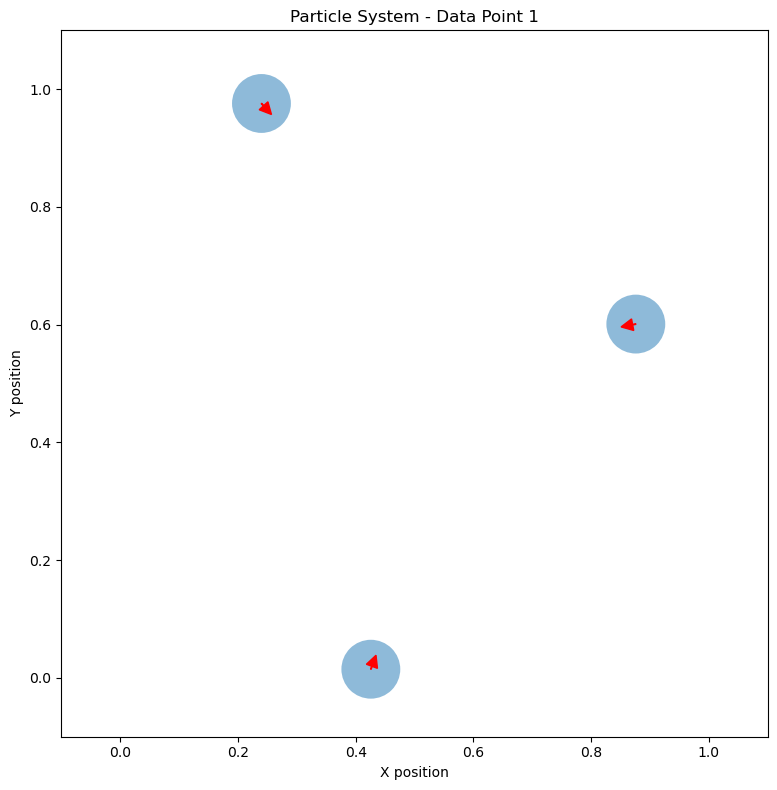

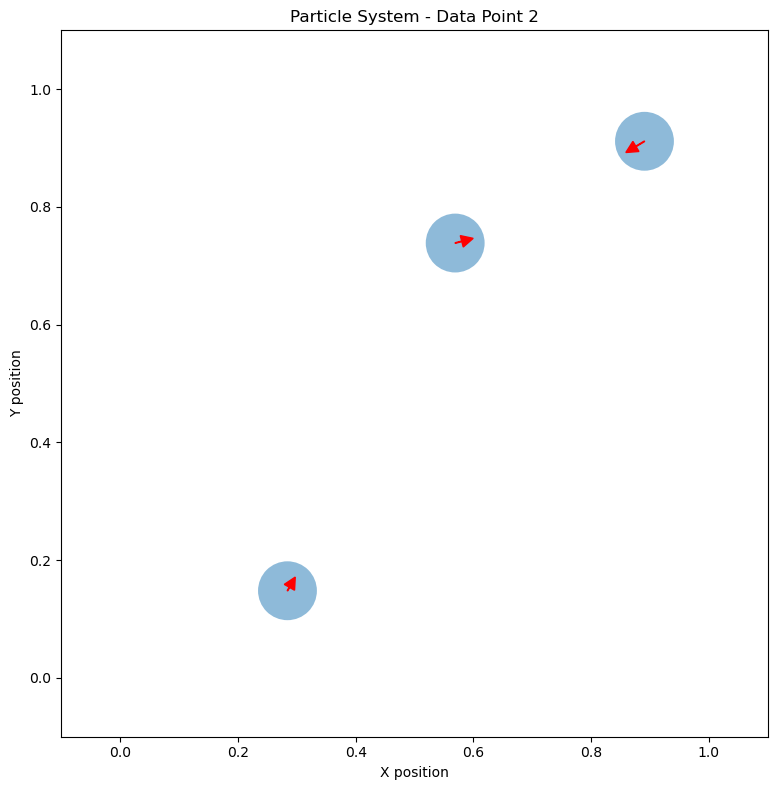

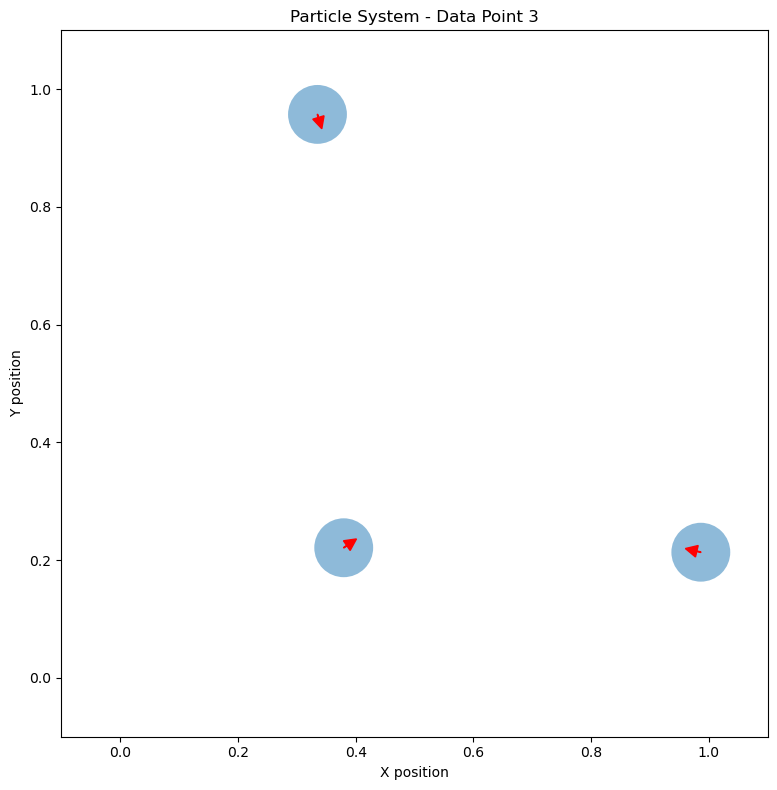

In [162]:
import matplotlib.pyplot as plt
import numpy as np

def plot_particle_system(data_point, index):
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Set plot limits
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)
    
    # Find the maximum mass for scaling
    max_mass = max(particle[2] for particle in data_point)
    
    # Plot particles and forces
    for particle in data_point:
        x, y, mass, force = particle
        
        # Plot particle as a circle
        radius = (mass / max_mass) / 20  # Scale size relative to maximum mass
        circle = plt.Circle((x, y), radius=radius, fill=True, alpha=0.5)
        ax.add_artist(circle)
        
        # Plot force arrow
        force_x, force_y = force
        # Scale arrow length
        scale = 0.002
        ax.arrow(x, y, force_x * scale, force_y * scale, 
                    head_width=0.02, head_length=0.02, fc='r', ec='r')
    
    ax.set_aspect('equal')
    ax.set_title(f'Particle System - Data Point {index}')
    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')
    
    plt.tight_layout()
    plt.show()

# Assuming particle_dataset is already generated
# Plot the first 3 data points
for i, data_point in enumerate(particle_dataset[:3]):
    plot_particle_system(data_point, i+1)

In [163]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data

class EdgeModel(MessagePassing):
    def __init__(self):
        super(EdgeModel, self).__init__(aggr='add')  # "Add" aggregation.
        self.mlp = nn.Sequential(
            nn.Linear(6, 64),  # 6 = 2 (pos) + 1 (mass) for each particle
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  # Output 2D force
        )

    def forward(self, x, edge_index):
        # print("edge index: ", edge_index)
        return self.propagate(edge_index, x=x)

    def message(self, x_i, x_j):
        tmp = torch.cat([x_i, x_j], dim=1)  # Concatenate features of both nodes
        # print(tmp)
        out = self.mlp(tmp)
        # print("out: ", out)
        return out

class NodeModel(nn.Module):
    def __init__(self):
        super(NodeModel, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(5, 32),  # 5 = 2 (pos) + 1 (mass) + 2 (aggregated force)
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 2)  # Output 2D force
        )

    def forward(self, x, edge_index, edge_attr):
        # The edge attributes have already been added when the Message Passing layer was
        # applied. Simply concatenate them with the node's features.
        # print("edge attributes: ", edge_attr)
        out = torch.cat([x, edge_attr], dim=1)
        return self.mlp(out)

class ParticleGNN(nn.Module):
    def __init__(self):
        super(ParticleGNN, self).__init__()
        self.edge_model = EdgeModel()
        self.node_model = NodeModel()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        # Edge Model
        edge_attr = self.edge_model(x, edge_index)
        
        # Node Model
        out = self.node_model(x, edge_index, edge_attr)
        
        return out

# Create a sample input
def create_sample_data(num_particles=3):
    x = torch.rand(num_particles, 3)  # [x, y, mass] for each particle
    edge_index = torch.tensor([[0, 0, 1, 1, 2, 2],
                               [1, 2, 0, 2, 0, 1]], dtype=torch.long)
    data = Data(x=x, edge_index=edge_index)
    return data

# Initialize the model
model = ParticleGNN()

# Create sample data
data = create_sample_data()
print(data)
print("node info: ", data.x)

# Forward pass
output = model(data)

print("Input:")
print(data.x)
print("\nOutput (forces):")
print(output)


Data(x=[3, 3], edge_index=[2, 6])
node info:  tensor([[0.7476, 0.2698, 0.7686],
        [0.2818, 0.8473, 0.3754],
        [0.1474, 0.8292, 0.6858]])
Input:
tensor([[0.7476, 0.2698, 0.7686],
        [0.2818, 0.8473, 0.3754],
        [0.1474, 0.8292, 0.6858]])

Output (forces):
tensor([[-0.1498,  0.1318],
        [-0.1446,  0.1388],
        [-0.1253,  0.1362]], grad_fn=<AddmmBackward0>)


In [164]:
x_dataset = []
y_dataset = []
edge_index = torch.tensor([[0, 0, 1, 1, 2, 2],
                           [1, 2, 0, 2, 0, 1]], dtype=torch.long)
for data_point in particle_dataset:
    x = torch.tensor([particle[:3] for particle in data_point], dtype=torch.float32)
    y = torch.tensor([particle[3] for particle in data_point], dtype=torch.float32)
    x_dataset.append(Data(x=x, edge_index=edge_index))
    y_dataset.append(y)


for particle in particle_dataset[:2]:
    print(particle)

print("\n")

for x in x_dataset[:2]:
    print(x.x)

print("\n")

for y in y_dataset[:2]:
    print(y)

[[0.8758128904051853, 0.6009938703277542, 1, [-2.6956844623059912, -0.5199538366627774]], [0.42566749108253144, 0.014681507667851146, 1, [0.9164262874841136, 2.4763553100782363]], [0.23985333971128697, 0.9757479804081758, 1, [1.7792581748218776, -1.956401473415459]]]
[[0.5689466000546509, 0.7386496232178617, 1, [5.597533474265035, 1.4582056186636732]], [0.8905125375155268, 0.9115334396768037, 1, [-7.261941209014108, -4.376098632630247]], [0.2840276914750455, 0.14799204546525435, 1, [1.6644077347490729, 2.9178930139665735]]]


tensor([[0.8758, 0.6010, 1.0000],
        [0.4257, 0.0147, 1.0000],
        [0.2399, 0.9757, 1.0000]])
tensor([[0.5689, 0.7386, 1.0000],
        [0.8905, 0.9115, 1.0000],
        [0.2840, 0.1480, 1.0000]])


tensor([[-2.6957, -0.5200],
        [ 0.9164,  2.4764],
        [ 1.7793, -1.9564]])
tensor([[ 5.5975,  1.4582],
        [-7.2619, -4.3761],
        [ 1.6644,  2.9179]])


In [165]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR  # Import StepLR scheduler

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the model to the device
model = model.to(device)

# Define a loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1)

# Define a learning rate scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.99)  # Reduce LR by factor of 0.1 every 10 epochs

# Training loop
num_epochs = 300  # Define the number of epochs
for epoch in range(num_epochs):
    model.train()
    
    # Training phase
    for x, y in zip(x_dataset, y_dataset):
        # Move data to the device
        x = x.to(device)
        y = y.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(x)
        
        # Compute loss
        loss = criterion(output, y)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    
    # Update the learning rate
    scheduler.step()  # Call the scheduler step at the end of each epoch
    
    # Print loss for every epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Learning Rate: {scheduler.get_last_lr()[0]:.10f}')

print("Training complete!")


Using device: cpu


Epoch [1/300], Loss: 3323758.0000, Learning Rate: 1.0000000000
Epoch [2/300], Loss: 332193.1875, Learning Rate: 1.0000000000
Epoch [3/300], Loss: 1229.4059, Learning Rate: 1.0000000000
Epoch [4/300], Loss: 1229.3812, Learning Rate: 1.0000000000
Epoch [5/300], Loss: 1229.3778, Learning Rate: 1.0000000000
Epoch [6/300], Loss: 1229.3774, Learning Rate: 1.0000000000
Epoch [7/300], Loss: 1229.3774, Learning Rate: 1.0000000000
Epoch [8/300], Loss: 1229.3773, Learning Rate: 1.0000000000
Epoch [9/300], Loss: 1229.3773, Learning Rate: 1.0000000000
Epoch [10/300], Loss: 1229.3774, Learning Rate: 0.9900000000
Epoch [11/300], Loss: 1229.3774, Learning Rate: 0.9900000000
Epoch [12/300], Loss: 1229.3774, Learning Rate: 0.9900000000
Epoch [13/300], Loss: 1229.3776, Learning Rate: 0.9900000000
Epoch [14/300], Loss: 1229.3774, Learning Rate: 0.9900000000
Epoch [15/300], Loss: 1229.3774, Learning Rate: 0.9900000000
Epoch [16/300], Loss: 1229.3774, Learning Rate: 0.9900000000
Epoch [17/300], Loss: 1229.3

In [166]:
# Ensure the model is in evaluation mode
model.eval()

# Move the model to the device if not already done
model = model.to(device)

# Prepare to store predictions
predicted_forces = []

# Iterate through the dataset to predict forces
for x in x_dataset:
    # Move data to the device
    x = x.to(device)
    
    # Make predictions
    with torch.no_grad():
        output = model(x)
        predicted_forces.append(output.cpu().numpy())

# Convert predicted forces to a format suitable for plotting
predicted_particle_dataset = []
for i, data_point in enumerate(particle_dataset):
    predicted_data_point = []
    for j, particle in enumerate(data_point):
        predicted_force = predicted_forces[i][j]  # Get predicted force
        particle_with_predicted_force = [particle[0], particle[1], particle[2], predicted_force.tolist()]
        predicted_data_point.append(particle_with_predicted_force)
    predicted_particle_dataset.append(predicted_data_point)

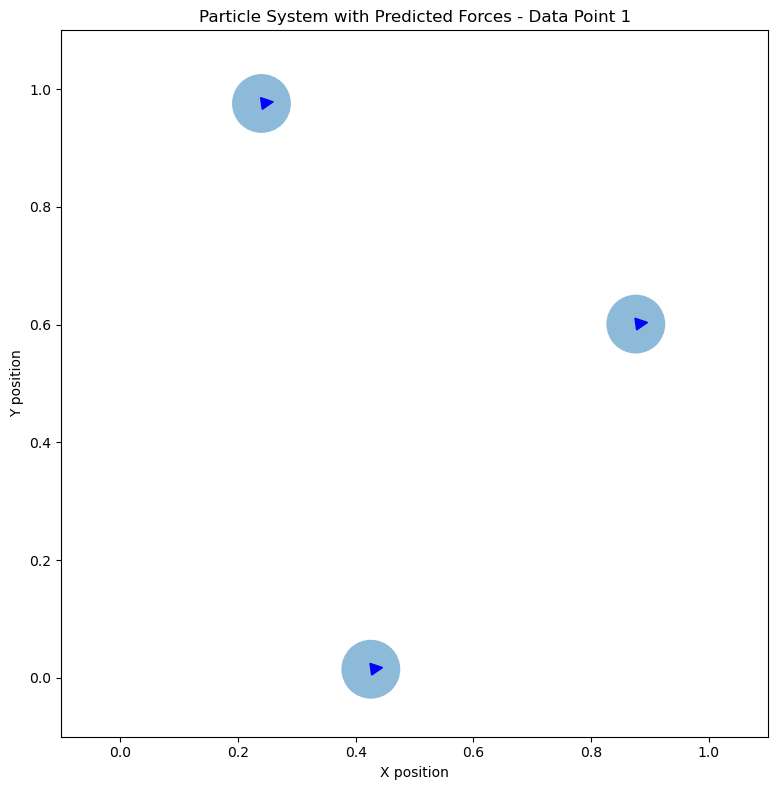

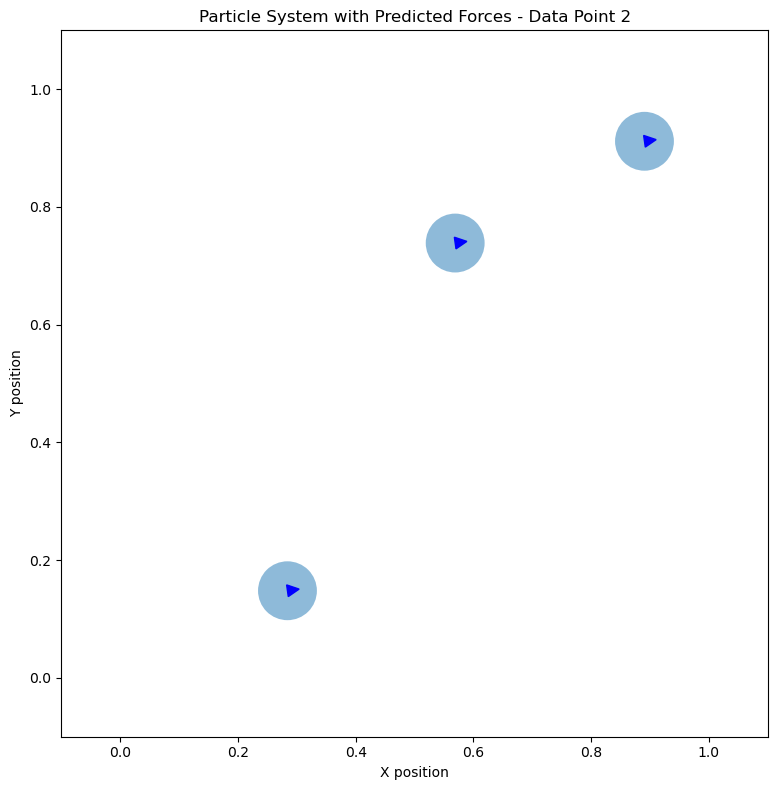

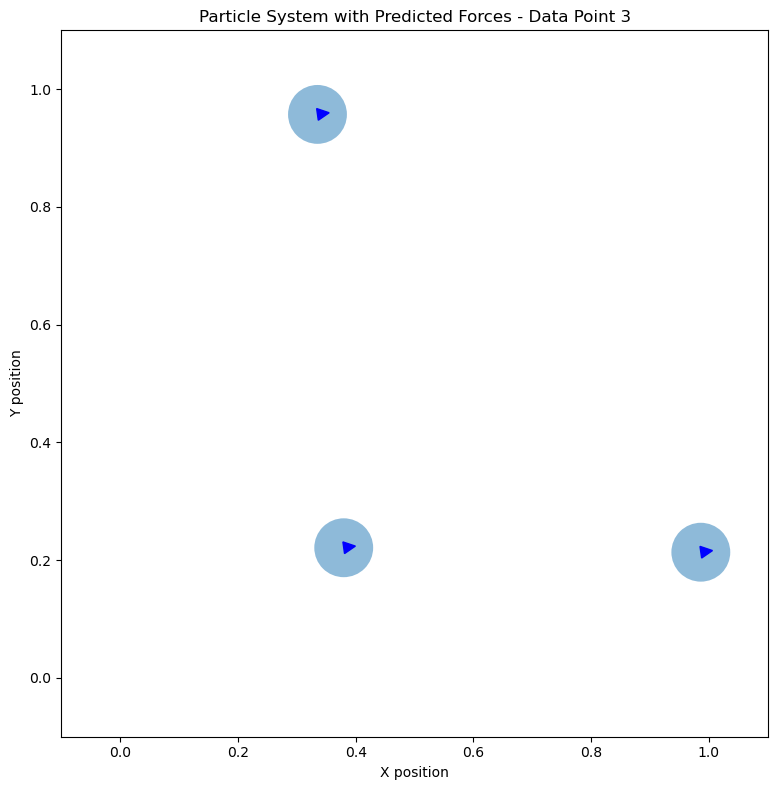

In [167]:
def plot_predicted_forces(data_point, index):
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Set plot limits
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)
    
    # Find the maximum mass for scaling
    max_mass = max(particle[2] for particle in data_point)
    
    # Plot particles and forces
    for particle in data_point:
        x, y, mass, force = particle
        
        # Plot particle as a circle
        radius = (mass / max_mass) / 20  # Scale radius relative to maximum mass
        circle = plt.Circle((x, y), radius=radius, fill=True, alpha=0.5)
        ax.add_artist(circle)
        
        # Plot predicted force arrow
        force_x, force_y = force
        # Scale arrow length
        scale = 0.002
        ax.arrow(x, y, force_x * scale, force_y * scale, 
                 head_width=0.02, head_length=0.02, fc='b', ec='b')
    
    ax.set_aspect('equal')
    ax.set_title(f'Particle System with Predicted Forces - Data Point {index}')
    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')
    
    plt.tight_layout()
    plt.show()

# Plot the predicted forces for the first 3 data points
for i, data_point in enumerate(predicted_particle_dataset[:3]):
    plot_predicted_forces(data_point, i + 1)